### Importing packages and data_utils.py

In [1]:
from climsim_utils.data_utils import data_utils

2023-06-13 19:17:09.963298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 19:17:31.611910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
!pwd

/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy


### Initialize folder paths

In [3]:
data_path = '/ocean/projects/atm200007p/walrus/for_jerry/train/'
norm_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/mooers_metrics/norm_factors/'
grid_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/mooers_metrics/test_data/E3SM-MMF_ne4_grid-info.orig.nc'
target_scoring_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/val_target_stride6.npy'
cvae_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/cVAE/cvae_preds_manual.h5'
hsr_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/HSR/hsr_preds_bestcrps.h5'
rpn_pred_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/rpn_pred_v1_stride6.npy'
cnn_pred_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/val_predict_cnn_reshaped_stride6_FINAL.npy'
mlp_pred_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/001_backup_phase-7_retrained_models_step2_lot-147_trial_0027.best.h5.npy'

### Create variables necessary for initialization

In [4]:
data_path = data_path
# input_vars = ['state_t','state_q0001','state_ps','pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX']
# target_vars = ['ptend_t','ptend_q0001','cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC','cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD']
grid_info = xr.open_dataset(grid_path)
inp_mean = xr.open_dataset(norm_path + 'mli_mean.nc')
inp_max = xr.open_dataset(norm_path + 'mli_max.nc')
inp_min = xr.open_dataset(norm_path + 'mli_min.nc')
out_scale = xr.open_dataset(norm_path + 'mlo_scale.nc')

### Create data_utils object

In [5]:
scoring_data = data_utils(data_path = data_path, 
                          grid_info = grid_info, 
                          inp_mean = inp_mean, 
                          inp_max = inp_max, 
                          inp_min = inp_min, 
                          out_scale = out_scale)

### Create pressure grid and set values for attributes

In [6]:
# set inputs and outputs to V1 subset
scoring_data.set_to_v1_vars()

# v1 inputs (name :: description :: dimension :: units): 

# 'state_t' :: air temperature :: 60 :: K 
# 'state_q0001' :: specific humidity :: 60 :: kg/kg
# 'state_ps' :: surface pressure :: 1 :: Pa
# 'pbuf_SOLIN' :: solar insolation :: 1 :: W/m^2
# 'pbuf_LHFLX' :: surface latent heat flux :: 1 :: W/m^2
# 'pbuf_SHFLX' :: surface sensible heat flux :: 1 :: W/m^2

# v1 outputs (name :: description :: dimension :: units): 

# 'ptend_t' :: heating tendency :: 60 :: K/s 
# 'ptend_q0001' :: moistening tendency :: 60 :: kg/kg/s
# 'cam_out_NETSW' :: net shortwave flux at surface :: 1 :: W/m^2
# 'cam_out_FLWDS' :: downward longwave flux at surface :: 1 :: W/m^2 
# 'cam_out_PRECSC' :: snow rate (liquid water equivalent) :: 1 :: m/s 
# 'cam_out_PRECC' :: rain rate :: 1 :: m/s
# 'cam_out_SOLS' :: downward visible direct solar flux to surface :: 1 :: W/m^2
# 'cam_out_SOLL' :: downward near-infrared direct solar flux to surface :: 1 :: W/m^2
# 'cam_out_SOLSD' :: downward diffuse solar flux to surface :: 1 :: W/m^2
# 'cam_out_SOLLD' :: downward diffuse near-infrared solar flux to surface :: 1 :: W/m^2

# set regular expressions for selecting data
scoring_data.set_regexps(data_split = 'scoring', regexps = ['E3SM-MMF.mli.0008-0[23456789]-*-*.nc', 
                                                            'E3SM-MMF.mli.0008-1[012]-*-*.nc', 
                                                            'E3SM-MMF.mli.0009-01-*-*.nc'])
# set temporal subsampling
scoring_data.set_stride_sample(data_split = 'scoring', stride_sample = 6)
# create list of files to extract data from
scoring_data.set_filelist(data_split = 'scoring')
# create pressure grid
pressure_grid_plotting = scoring_data.get_pressure_grid_plotting(data_split = 'scoring')
# load target output
scoring_data.target_scoring = np.load(target_scoring_path)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4380/4380 [03:24<00:00, 21.43it/s]


### Load predictions from each model

In [7]:
scoring_data.model_names = ['cVAE','HSR','RPN','CNN', 'MLP']
preds = [scoring_data.get_pred_h5(load_path = cvae_pred_path), 
         scoring_data.get_pred_h5(load_path = hsr_pred_path), 
         scoring_data.get_pred_npy(load_path = rpn_pred_path), 
         scoring_data.get_pred_npy(load_path = cnn_pred_path), 
         scoring_data.get_pred_npy(load_path = mlp_pred_path)]
scoring_data.preds_scoring = dict(zip(scoring_data.model_names, preds))

### Plot pressure latitude R2 analysis

/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/data_utils.py:863: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  contour_plot = ax[0,i].pcolor(X, Y, coeff,cmap='Blues', vmin = 0, vmax = 1) # pcolormesh
/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/data_utils.py:870: RuntimeWarning: divide by zero encountered in divide
  coeff = 1 - np.sum( (pred_moist_daily_long-test_moist_daily_long)**2, axis=1)/np.sum( (test_moist_daily_long-np.mean(test_moist_daily_long, axis=1)[:,None,:])**2, axis=1)
/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/data_utils.py:874: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, p

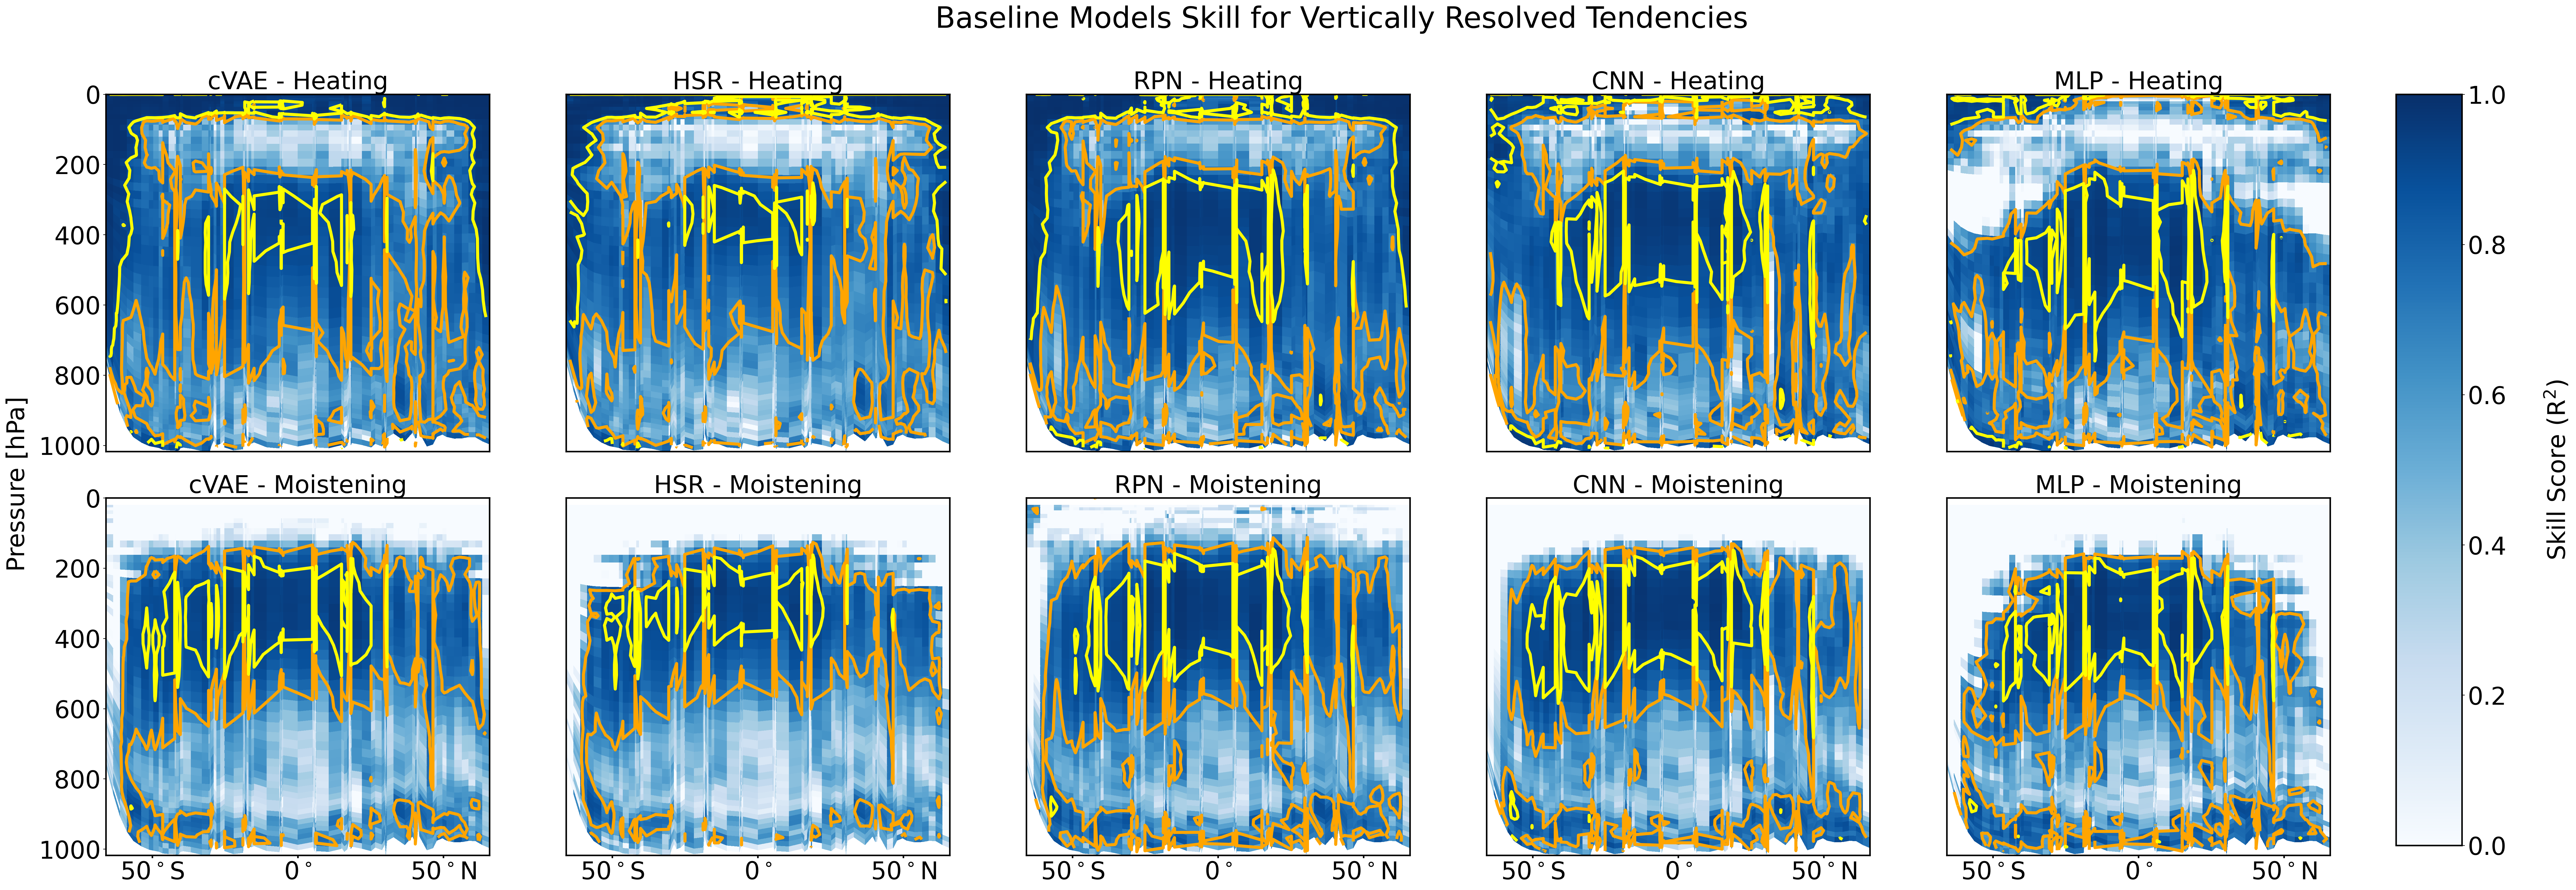

<Figure size 640x480 with 0 Axes>

In [8]:
%config InlineBackend.figure_format = 'retina'
scoring_data.plot_r2_analysis(pressure_grid_plotting = pressure_grid_plotting)